In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.preprocessing import Normalizer

In [22]:
CREDIT_SCORE_PATH = r"E:\jupyter-workspace\datas"

In [23]:
credit = pd.read_csv(os.path.join(CREDIT_SCORE_PATH, "german-beautified.csv"),sep=";")

In [24]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
Status of existing checking account                         1000 non-null object
Duration in months                                          1000 non-null int64
Credit history                                              1000 non-null object
Purpose                                                     1000 non-null object
Credit amount                                               1000 non-null int64
Savings account/bonds                                       1000 non-null object
Present employment since                                    1000 non-null object
Installment rate in percentage of disposable income         1000 non-null int64
Personal status and sex                                     1000 non-null object
Other debtors / guarantors                                  1000 non-null object
Present residence since                                     1000 non-null int64
Propert

In [25]:
credit.describe()

,Duration in months,Credit amount,Installment rate in percentage of disposable income,Present residence since,Age in years,Number of existing credits at this bank,Number of people being liable to provide maintenance for
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [26]:
credit["Status of existing checking account"].value_counts()

No checking account    394
Negative               274
0 - 200                269
Over 200                63
Name: Status of existing checking account, dtype: int64

In [27]:
cat_attribs = ["Status of existing checking account", "Credit history", "Purpose", 
              "Savings account/bonds", "Present employment since", "Personal status and sex",
              "Other debtors / guarantors", "Property", "Other installment plans", 
              "Housing", "Job", "Telephone", "Foreign worker"]
num_attribs = ["Duration in months", "Credit amount", "Installment rate in percentage of disposable income", "Present residence since",
              "Age in years", "Number of existing credits at this bank", "Number of people being liable to provide maintenance for"]

In [28]:
for cat_attrib in cat_attribs:
    print(cat_attrib)
    print(credit[cat_attrib].value_counts())
    print()

Status of existing checking account
No checking account    394
Negative               274
0 - 200                269
Over 200                63
Name: Status of existing checking account, dtype: int64

Credit history
existing credits paid back duly till now                       530
critical account/ other credits existing (not at this bank)    293
delay in paying off in the past                                 88
all credits at this bank paid back duly                         49
no credits taken / all credits paid back duly                   40
Name: Credit history, dtype: int64

Purpose
radio/television       280
car (new)              234
furniture/equipment    181
car (used)             103
business                97
education               50
repairs                 22
domestic appliances     12
others                  12
retraining               9
Name: Purpose, dtype: int64

Savings account/bonds
less than 100                   603
unknown / no savings account    183
100 to 500  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C7C2EE9240>,
      dtype=object)

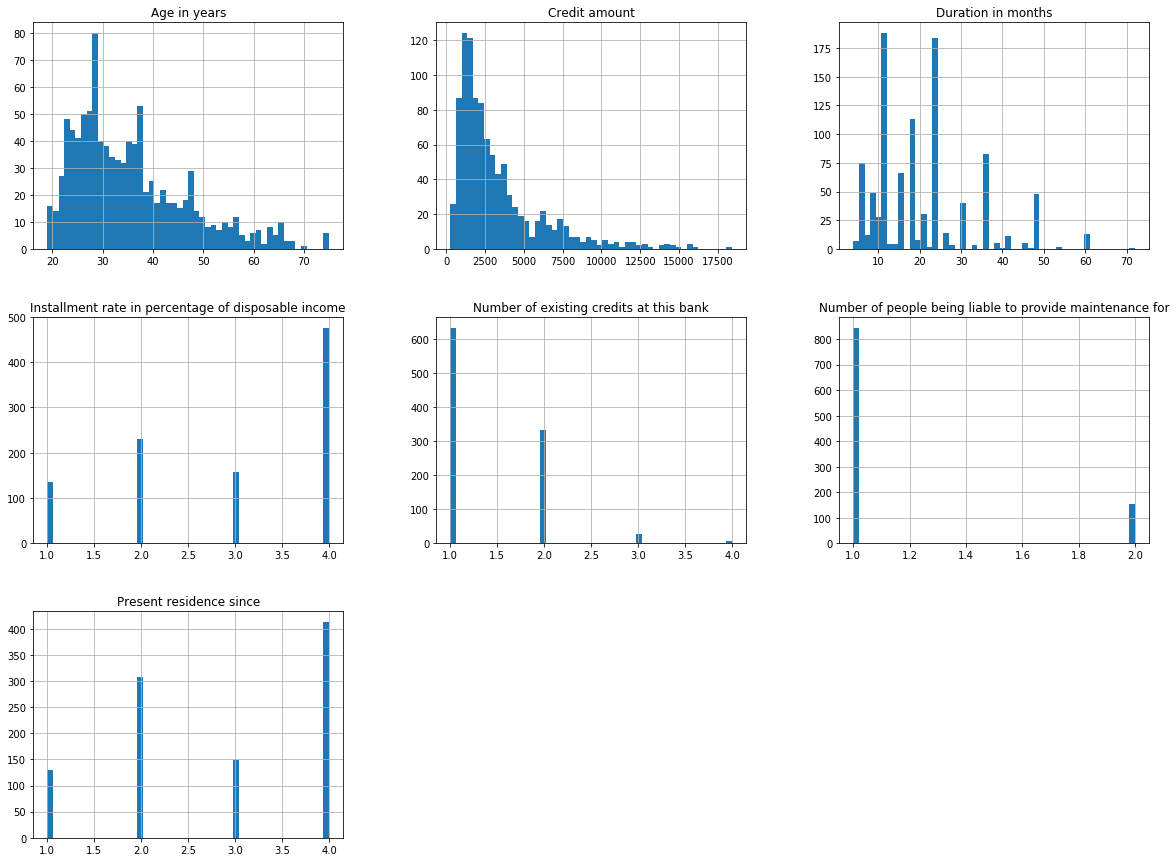

In [29]:
%matplotlib inline
credit.hist(bins=50, figsize=(20,15))

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelBinarizer
class MyLabelBinarizer(BaseEstimator, TransformerMixin):

    def __init__(self, attribute_names) -> None:
        self.attribute_names = attribute_names
        self.feature_names = []

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        label_binarizer = LabelBinarizer()

        if len(X.shape) == 1:
            row_c, = X.shape
            column_c = 1
        else:
            row_c, column_c = X.shape
        
        feature_fix = None

        for column in range(column_c):
            ret = label_binarizer.fit_transform(X[:, column])
            if feature_fix is None:
                feature_fix = ret
            else:
                feature_fix = np.concatenate((feature_fix, ret), axis=1)
            attribute_name = self.attribute_names[column]
            if label_binarizer.y_type_ == "binary":
                self.feature_names.append(attribute_name)
            else:
                for clz in label_binarizer.classes_:
                    self.feature_names.append("%s_%s" % (attribute_name, clz))
        return feature_fix

class DataFrameSelector(BaseEstimator, TransformerMixin):

    def __init__(self, attribute_names) -> None:
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None, **fit_params):
        return X[self.attribute_names].values

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

In [35]:
Y = MyLabelBinarizer(["Score"]).fit_transform(credit["Score"].values.reshape(-1,1))
cat_pipeline = Pipeline([("selector", DataFrameSelector(cat_attribs)),("binarizer", MyLabelBinarizer(cat_attribs))])
num_pipeline = Pipeline([("selector", DataFrameSelector(num_attribs))])

full_pipeline = FeatureUnion(transformer_list=[("num_pipeline", num_pipeline), ("cat_pipeline", cat_pipeline)])

X = full_pipeline.fit_transform(credit)
all_feature = []
all_feature.extend(num_attribs)
all_feature.extend(cat_pipeline.named_steps["binarizer"].feature_names)

In [37]:
from sklearn.tree import DecisionTreeClassifier
tree_clz = DecisionTreeClassifier()
tree_clz.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [38]:
from sklearn.metrics import accuracy_score

In [39]:
y_pred = tree_clz.predict(X)
accuracy_score(Y, y_pred)

1.0

In [40]:
print(tree_clz.score(X, Y))
print(tree_clz.classes_)
print(tree_clz.feature_importances_)
print(len(tree_clz.feature_importances_))
print(len(all_feature))

1.0
[0 1]
[0.12165307 0.12347974 0.02473507 0.03111915 0.07846922 0.01264052
 0.         0.00555556 0.0103205  0.10396478 0.00956088 0.02346769
 0.00643885 0.00708996 0.0144844  0.00998516 0.00170068 0.03936018
 0.02617151 0.         0.02443981 0.01198281 0.00357143 0.00883987
 0.0017379  0.0043956  0.00529762 0.00913228 0.01556452 0.00610501
 0.00357143 0.00790559 0.0166533  0.01920564 0.02372105 0.01195887
 0.00238095 0.00194581 0.00600907 0.0031746  0.00877296 0.
 0.00650429 0.00420088 0.03001562 0.01427126 0.         0.00918367
 0.01180551 0.         0.00398382 0.01210615 0.00931257 0.
 0.00964066 0.         0.00911977 0.02526351 0.00802927]
59
59


In [41]:
feature_importances = pd.Series(tree_clz.feature_importances_, index=all_feature)

In [42]:
feature_importances.sort_values(ascending=False)

Credit amount                                                                 0.123480
Duration in months                                                            0.121653
Status of existing checking account_No checking account                       0.103965
Age in years                                                                  0.078469
Purpose_car (new)                                                             0.039360
Present residence since                                                       0.031119
Property_car or other                                                         0.030016
Purpose_car (used)                                                            0.026172
Telephone                                                                     0.025264
Installment rate in percentage of disposable income                           0.024735
Purpose_education                                                             0.024440
Present employment since_less than 1 year  

In [43]:
from pandas.plotting import scatter_matrix

In [44]:
all_feature.append("Score")


In [45]:
credit_fix = pd.DataFrame(np.concatenate([X,Y], axis=1), columns=all_feature)

TypeError: heatmap() missing 1 required positional argument: 'data'

In [ ]:
corr_metrix = credit_fix.corr()

In [ ]:
corr_metrix = corr_metrix.nlargest(10,"Score")

In [ ]:
%matplotlib inline
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 14
columns = corr_metrix["Score"].index
plt.figure(figsize=(20,15))
sns.heatmap(corr_metrix[columns], annot=True, cbar=True,xticklabels=columns, yticklabels=columns,fmt=".2f", square=True, )


In [ ]:
X.shape

In [ ]:
Y.shape

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
score = cross_val_score(tree_clz, X, Y, scoring="accuracy", n_jobs=4,cv=10,verbose=5)
score

In [ ]:
np.sum(np.array([[1,2,3],[4,5,6]]),axis=0)

In [ ]:
np.concatenate([np.array([[1],[2]]), np.array([[3],[4]])],axis=1)

In [53]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer

In [56]:
mlb = MultiLabelBinarizer()
mlb.fit_transform(np.array([["a","b","c"],["d","e","f"]]))

array([[1, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 1]])

In [69]:
np.expand_dims(credit.iloc[:,[0,2]].values,axis=1)

array([[['Negative',
         'critical account/ other credits existing (not at this bank)']],

       [['0 - 200', 'existing credits paid back duly till now']],

       [['No checking account',
         'critical account/ other credits existing (not at this bank)']],

       ...,

       [['No checking account',
         'existing credits paid back duly till now']],

       [['Negative', 'existing credits paid back duly till now']],

       [['0 - 200',
         'critical account/ other credits existing (not at this bank)']]],
      dtype=object)

In [66]:
le = LabelEncoder()
le.fit_transform(np.expand_dims(credit.iloc[:,0].values,axis=1))

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 0, 2, 1, 1, 2, 2, 0, 2, 0, 0, 1, 0, 1, 1, 1, 2, 1, 0, 2, 2, 1,
       1, 0, 2, 1, 2, 3, 0, 1, 0, 1, 0, 2, 3, 0, 2, 3, 3, 0, 2, 0, 0, 1,
       1, 2, 2, 1, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 3, 1, 0, 0, 0, 0, 2, 2,
       2, 0, 2, 2, 2, 2, 1, 0, 1, 1, 1, 0, 2, 0, 2, 2, 2, 1, 1, 2, 0, 0,
       1, 1, 2, 1, 2, 3, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 0,
       0, 3, 0, 2, 1, 2, 1, 1, 1, 0, 1, 2, 2, 3, 0, 1, 1, 0, 0, 1, 0, 1,
       2, 2, 2, 2, 2, 0, 0, 3, 3, 0, 1, 1, 2, 0, 1, 2, 1, 2, 2, 2, 3, 0,
       0, 1, 1, 1, 0, 2, 2, 2, 2, 0, 2, 2, 1, 0, 2, 0, 1, 2, 0, 0, 1, 2,
       1, 1, 2, 1, 2, 0, 1, 2, 0, 2, 0, 0, 1, 0, 2, 0, 0, 2, 0, 0, 2, 0,
       0, 0, 2, 1, 2, 1, 2, 1, 2, 0, 1, 2, 2, 2, 1, 3, 2, 0, 1, 3, 1, 2,
       0, 1, 2, 2, 2, 2, 0, 1, 2, 1, 3, 2, 2, 0, 2, 1, 0, 0, 2, 1, 1, 2,
       1, 2, 2, 2, 2, 2, 3, 2, 1, 3, 0, 2, 0, 0, 2, 1, 2, 2, 1, 1, 1, 2,
       2, 0, 2, 2, 1, 2, 2, 2, 0, 0, 1, 2, 2, 1, 2, 2, 2, 2, 3, 2, 0, 1,
       1, 0, 0, 1, 2, 0, 1, 3, 2, 0, 2, 2, 2, 0, 2,

In [74]:
class MyLabelEncoder(BaseEstimator, TransformerMixin):

    def __init__(self) -> None:
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        le = LabelEncoder()
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=1)
        rows, columns = X.shape

        f = None
        for i in range(columns):
            encoder_r = np.expand_dims(le.fit_transform(X[:, i]), axis=1)
            if f is None:
                f = encoder_r
            else:
                f = np.concatenate([f, encoder_r], axis=1)
        return f

In [76]:
le = MyLabelEncoder()
X = le.fit_transform(credit[cat_attribs].values)

In [89]:
num_pipeline = Pipeline([("selector", DataFrameSelector(num_attribs)), ("scale", Normalizer())])
cat_pipeline = Pipeline([("selector", DataFrameSelector(cat_attribs)), ("labelencoder", MyLabelEncoder())])

all_pipeline= FeatureUnion(transformer_list=[("num_pipeline", num_pipeline),("cat_pipeline", cat_pipeline)])

X = all_pipeline.fit_transform(credit)

In [90]:
tree_clz = DecisionTreeClassifier()
tree_clz.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [91]:
y_pred = tree_clz.predict(X)
accuracy_score(Y, y_pred)

1.0

In [84]:
from sklearn.model_selection import cross_val_score

In [92]:
score = cross_val_score(tree_clz, X, Y, scoring="accuracy", cv=10, n_jobs=4,verbose=5)

[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:    3.0s remaining:    2.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    3.0s finished


In [93]:
score

array([0.72, 0.73, 0.7 , 0.68, 0.71, 0.65, 0.65, 0.71, 0.71, 0.64])

In [87]:
print(score.mean())
print(score.max())
print(score.min())

0.695
0.76
0.63


In [94]:
print(score.mean())
print(score.max())
print(score.min())

0.69
0.73
0.64
